# AAA Northeast Customer Clustering

## Assumptions
- We only have the current address of the customers, so we assume that most customers live in the same city most of the time.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read data
df = pd.read_csv('member_sample.csv')
#df = df[~df['Member Key'].isnull()].set_index('Member Key')
df.shape

(21344, 113)

In [3]:
df.isnull().sum().value_counts()

1        20
0        16
7347     16
9334      8
4669      6
5463      3
7400      3
13167     3
12562     2
7348      2
9531      2
7491      2
7391      2
15961     1
21336     1
9715      1
20484     1
7433      1
11153     1
9955      1
36        1
7602      1
20520     1
3250      1
17652     1
7394      1
20612     1
10423     1
9401      1
7975      1
7483      1
12561     1
21344     1
7359      1
20703     1
9027      1
7367      1
8163      1
5453      1
20956     1
20849     1
dtype: int64

## Data Preprocessing

### Column Selection
#### Identify Target Variables
- Products: 
    1. FSV CMSI
    2. FSV Credit Card
    3. FSV Deposit Program
    4. FSV Home Equity
    5. FSV ID Theft
    6. FSV Mortgage
    7. INS Client
    8. TRV Globalware
    9. New Mover
   
   
- Cost: Total Cost (Roadside data)

#### Select Key Columns
The rules of selecting columns
1. Use the granular column reasonable number of unique values when available (Ex: ZIP instead of state or ZIP9)
2. Use the more complete column within columns providing same information (Ex: gender instead of right_gender)
3. Use only one column within a group of correlated columns (Ex: Use tenure and drop Join AAA Date)information at household level.
4. Drop columns that satisfy the following criteria:
    - Have the same value on all or the majority of data (ex: Member Flag, Language)
    - Contain high missing values (ex: Reason Joined)
    - Should not be used for decision making (ex: Race)
    - Only have partial information (ex: Months from Join to Cancel is only for cancelled members)
    - Not informative (ex: Address Change Date)
    - Can't be aggregated to household level after data exploration (Ex: Education, Occupation, Vehicle)
    - Others (ex: Individual keys)
5. Keep only total cost from roadside data as the rest columns could not be aggregated

In [4]:
product_list = ['FSV CMSI Flag', 'FSV Credit Card Flag', 'FSV Deposit Program Flag', 
                'FSV Home Equity Flag', 'FSV ID Theft Flag', 'FSV Mortgage Flag',
                'INS Client Flag', 'TRV Globalware Flag', 'New Mover Flag']

cost = ['Total Cost']

selected_cols = ['Member Key', 'Household Key', 'ZIP', 'Number of Children', 
                 'Length Of Residence', 'Mail Responder', 'Home Owner', 'Income',  
                 'Dwelling Type', 'Credit Ranges', 'Do Not Direct Mail Solicit', 
                 'Email Available', 'ERS ENT Count Year 1', 'ERS ENT Count Year 2', 
                 'ERS ENT Count Year 3', 'ERS Member Cost Year 1', 'ERS Member Cost Year 2', 
                 'ERS Member Cost Year 3', 'Member Status', 'Member Tenure Years', 'Member Type', 
                 'Mosaic Household', 'Mosaic Global Household', 'kcl_B_IND_MosaicsGrouping']

### Individual Level
#### Aggregate Cost by Year
Member data is duplicated for the same individual with multiple records of roadside data. To avoid duplication, aggregate roadside data (cost) to individual level by Member Key, the unique key for member data.

In [7]:
df['Cost Year'] = pd.DatetimeIndex(pd.to_datetime(df['SC Date'], format="%Y/%m/%d %H:%M")
                                  ).year.fillna('0').astype('int64')
df['Cost Year'].unique()

array([   0, 2017, 2016, 2015, 2019, 2014, 2018], dtype=int64)

In [8]:
df['Cost Year'].value_counts()

0       7347
2015    3851
2016    3551
2014    2242
2019    2151
2017    1160
2018    1042
Name: Cost Year, dtype: int64

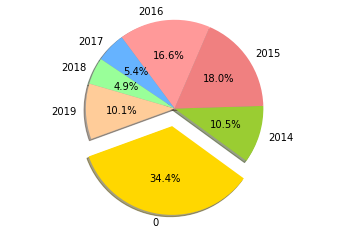

In [9]:
import matplotlib.pyplot as plt

# Data to plot
labels = 0,2014, 2015,2016,2017,2018,2019
sizes = [7346,2242,3851,3551,1160,1042,2151]
colors = ['gold', 'yellowgreen', 'lightcoral','#ff9999','#66b3ff','#99ff99','#ffcc99']
explode = (0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=200)

plt.axis('equal')
plt.show()

In [10]:
df_cost = df[['Total Cost', 'Cost Year']
             ].reset_index().groupby(['Member Key', 'Cost Year']
                                    ).sum().reset_index().pivot(index='Member Key',
                                                                columns='Cost Year',
                                                                values='Total Cost').fillna(0)
df_cost['Total Cost'] = df_cost.sum(axis=1)
df_cost = df_cost.iloc[:,1:]
df_cost.columns = ['Cost 2014', 'Cost 2015', 'Cost 2016', 
                   'Cost 2017', 'Cost 2018', 'Cost 2019', 'Total Cost']
df_cost.head()

KeyError: 'Member Key'

In [11]:
df_cost.shape

NameError: name 'df_cost' is not defined

#### Remove Duplication

In [ ]:
df_member = df.loc[:, product_list + selected_cols
                  ].drop_duplicates().join(df_cost)
df_member.shape

In [ ]:
df_member.head()

#### Remove Cancelled members

In [ ]:
df_member['Member Status'].value_counts()

In [ ]:
df_member = df_member[df_member['Member Status'] != 'CANCELLED']

#### Transfer Data Type
- Transfer to 1 and 0: Products, Mail Responder
- Transfer to numeric than use mean: Income, Credit Ranges, Number of Children
- Create new columns: Member Type

#### 3.1 Convert Male and Female to 0 and 1

In [ ]:
df_children = df_member[['Number of Children']].replace({'No children': 0,
                                                         'One Child': 1,
                                                         'Two Children': 2,
                                                         'Three Children': 3,
                                                         'Four Children': 4,
                                                         'Five Children': 5,
                                                         'Six Children': 6})
df_children.head()

In [ ]:
df_income = df_member[['Income']].replace({'Under 10K': 5000,
                                           '10-19,999': 15000,
                                           '20-29,999': 25000,
                                           '30-39,999': 35000,
                                           '40-49,999': 45000, 
                                           '50-59,999': 55000,
                                           '60-69,999': 65000,
                                           '70-79,999': 75000,
                                           '80-89,999': 85000,
                                           '90-99,999': 95000,
                                           '100-149,999': 125000,
                                           '150 - 174,999': 162500, 
                                           '175 - 199,999': 187500,
                                           '200 - 249,999': 225000,
                                           '250K+': 250000})
df_income.head()

In [ ]:
df_credit = df_member[['Credit Ranges']].replace({'499 & Less': 250,
                                                  '500-549': 525,
                                                  '550-599': 575,
                                                  '600-649': 625,
                                                  '650-699': 675,
                                                  '700-749': 725,
                                                  '750-799': 775,
                                                  '800+': 800,
                                                  'Unknown': np.nan
                                                 })
df_credit.head()

In [ ]:
# Occup_unknown = df_member['Occupation Code'] == 'Unknown'
# df_occup = pd.DataFrame({'Occupation': pd.concat([df_member['Occupation Code'][~Occup_unknown],
#                                                   df_member['Occupation Group'][Occup_unknown]])})
# df_occup.head()

In [ ]:
df_member[product_list + ['Mail Responder', 'Number of Children',
                          'Income', 'Credit Ranges']].tail()

In [ ]:
df_transform = df_member.drop(product_list + 
                              ['Mail Responder', 'Number of Children', 
                               'Income', 'Credit Ranges'],
                              axis = 1
                             ).join(df_bool).join(df_children).join(df_income).join(df_credit)
df_transform.tail()

In [ ]:
df_transform = df_transform.assign(PrimaryMember = 
                                       [1 if x == 'Primary' else 0 
                                            for x in df_transform['Member Type']],
                                   AssociateMember = 
                                       [1 if x == 'Associate' else 0 
                                            for x in df_transform['Member Type']])
df_transform[['Member Type', 'PrimaryMember', 'AssociateMember']].tail()

In [ ]:
df_transform = df_transform.drop(['Member Status', 'Member Type'], axis = 1)

In [ ]:
df_transform.columns

### Household Level
#### Non-Numeric Columns
To aggregate non-numeric columns, we need to check if the non-numeric values within a household are too diverse. If the variables are consistent within the majority of household, we can use mode to get the variable that is representative to the household without misinterpreting the true information.

In [ ]:
# Number of households with more than one values in each non-numeric columns
pd.DataFrame(df_transform.loc[:, [df_transform[x].dtype == 'O' for x in df_transform]
                             ].join(df_transform['Household Key']
                                   ).groupby(['Household Key']).nunique() > 1).sum()

From the result we can confidently aggregate Home Owner, Dwelling Type and Mosaic columns by taking mode, because only a handful of households have more than two values in these columns.

In [ ]:
categorical_cols = ['ZIP', 'Home Owner', 'Dwelling Type', 'Mosaic Household', 
                    'Mosaic Global Household', 'kcl_B_IND_MosaicsGrouping']
df_household_cat = df_transform.fillna('Not Set'
                                       ).groupby(['Household Key']
                                                )[categorical_cols].agg(lambda x: 
                                                                        x.value_counts().index[0])
df_household_cat['ZIP'] = df_household_cat['ZIP'].astype('category')
df_household_cat.head()

#### Numeric Columns

In [ ]:
df_household_num = df_transform.groupby(['Household Key']
                                   ).agg({'Member Key': 'count',
                                          'Length Of Residence': 'mean',
                                          'Do Not Direct Mail Solicit': 'mean',
                                          'Email Available': 'mean', 
                                          'ERS ENT Count Year 1': ['sum', 'mean'],
                                          'ERS ENT Count Year 2': ['sum', 'mean'],
                                          'ERS ENT Count Year 3': ['sum', 'mean'],
                                          'ERS Member Cost Year 1': ['sum', 'mean'],
                                          'ERS Member Cost Year 2': ['sum', 'mean'],
                                          'ERS Member Cost Year 3': ['sum', 'mean'],
                                          'Member Tenure Years': 'mean',
                                          'Cost 2014': 'sum',
                                          'Cost 2015': 'sum',
                                          'Cost 2016': 'sum',
                                          'Cost 2017': 'sum',
                                          'Cost 2018': 'sum',
                                          'Cost 2019': 'sum',
                                          'Total Cost': 'sum',
                                          'Mail Responder': 'mean',
                                          'Number of Children': 'mean',
                                          'Income': 'mean',
                                          'Credit Ranges': 'mean',
                                          'AssociateMember': 'sum',
                                          'PrimaryMember': 'sum'
                                         })
df_household_num.columns = [' '.join(col).strip() for col in df_household_num.columns.values]
df_household_num.head()

#### Products

In [ ]:
df_household_product = df_transform.groupby(['Household Key']
                                           )[product_list].agg(max)
df_household_product.head()

In [ ]:
df_household = df_household_cat.join(df_household_num).join(df_household_product)
df_household.head()

In [ ]:
df_household['Dwelling Type'].value_counts()

#### Imputation of Missing Values
The missing values in categorical columns have been filled with 'Not Set'. Now the missing values in numerical columns will be filled with median.

In [ ]:
df_household.info()

In [ ]:
# Observation before filling NA
sns.pairplot(df_household[['Income mean', 'Mail Responder mean', 'Length Of Residence mean',
                           'Credit Ranges mean', 'Number of Children mean', 'Total Cost sum']].fillna(0))
plt.show()

In [ ]:
from sklearn.impute import SimpleImputer

In [ ]:
numeric_features = df_household.select_dtypes(include=['float64', 'int64']).columns
imp_med = SimpleImputer(missing_values=np.nan, strategy='median')
df_num = pd.DataFrame(imp_med.fit_transform(df_household[numeric_features]))
df_num.columns = numeric_features
df_num.index = df_household.index
df_num.head()

#### One Hot Encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
categorical_features = df_household.select_dtypes(include=['category', 'object']).columns
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df_household[categorical_features])
df_cat = pd.DataFrame(enc.transform(df_household[categorical_features]).toarray())
df_cat.columns = enc.get_feature_names()
df_cat.index = df_household.index
df_cat.head()

### Final Dataset

In [ ]:
X = df_num.join(df_cat)
X.info()

In [ ]:
X.head()

In [ ]:
# Save data
X.to_csv('processed_data.csv')